# Ước lượng phân vị Harrell-Davis

### Bs. Lê Ngọc Khả Nhi


## Giới thiệu:

Năm 1982, hai nhà thống kê Frank Harrell và C. Davis đã thiết kế một phương pháp phi tham số cho phép ước lượng giá trị của bất cứ phân vị nào trên một tập hợp dữ liệu. 

Harrell, F.E. & Davis, C.E. (1982) A new distribution-free quantile estimator. Biometrika, 69, 635-640.

Do đặc tính phi tham số, phương pháp Harrell-Davis có thể áp dụng một cách phổ quát cho bất cứ dữ liệu nào mà không cần biết về đặc tính phân phối.

Trong bài thực hành hôm nay, Nhi sẽ cùng các bạn viết code thủ công để ứng dụng phương pháp Harrel-Davis, mục tiêu sau cùng là tạo ra một kiểm định phi tham số mạnh và linh hoạt hơn rất nhiều so với các công cụ mà ta từng biết như Wilcoxon, MannWhitney U...

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices

# Hàm ước tính phân vị

Đầu tiên, Nhi đưa quy trình tính toán phân vị theo Harrell - Davis vào một hàm, dữ liệu đầu vào là numpy array 1D, kết quả xuất ra là 1 dictionary với key = bách phân vị cần ước tính, và value tương ứng là giá trị bách phân vị tính được.

In [3]:
def hd_est(x, qseq = [0.5]):
    '''Hàm ước tính phân vị theo Harrell-Davis
    @ Arguments:
    x: list, numpy array hoặc pandas series
    qseq: list, giá trị nằm trong khoảng 0,1
    
    @ Output: Dictionary có dạng {'q': Harrell-Davis quantile,}
    '''
    if isinstance(x, list):
        x = np.array(x)
    
    assert x.ndim == 1, 'Không dùng được cho array có hơn 1 chiều'
    assert len(x) >= 3, 'Dữ liệu quá ít, cần ít nhất 3 phần tử'
    assert np.abs(np.array(qseq)).max() < 1, 'Bách phân vị phải nằm trong khoảng 0,1'
    
    x = x[~np.isnan(x)]
    xs = np.sort(x, axis=0)
    n = len(x)
    vec = np.arange(n)
    
    xq = dict.fromkeys(qseq)
    
    for q in qseq:
        m1 = (n + 1) * q
        m2 = (n + 1) * (1 - q)
        wx = (stats.beta.cdf(vec/n, m1, m2) -
             stats.beta.cdf((vec-1)/n, m1, m2))
        
        xq[q] = (wx * xs).sum()
        
    return xq

In [17]:
hd_est(x = [1,2,])

AssertionError: Dữ liệu quá ít, cần ít nhất 3 phần tử

In [20]:
hd_est(x = np.array([[1,2,3],[4,5,6]]) )

AssertionError: Không dùng được cho array có hơn 1 chiều

In [23]:
hd_est(x = np.array([1,2,3]), qseq = [50] )

AssertionError: Bách phân vị phải nằm trong khoảng 0,1

Đầu tiên chúng ta thử ước tính bách phân vị cho một phân bố chuẩn: Theo nguyên tắc, kết quả của hàm hd_est phải tương đương với những hàm quantile khác:

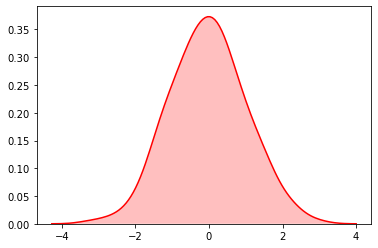

In [2]:
np.random.seed(123)

x1 = np.random.normal(size=300)

sns.kdeplot(x1, shade = True, color ='red')

In [4]:
np.quantile(x1, [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95], axis = 0)

array([-1.60834951, -1.32674689, -0.73315073, -0.01822824,  0.6663193 ,
        1.27829453,  1.65191233])

In [5]:
pd.Series(x1).quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

0.05   -1.608350
0.10   -1.326747
0.25   -0.733151
0.50   -0.018228
0.75    0.666319
0.90    1.278295
0.95    1.651912
dtype: float64

In [42]:
hd_est(x1, [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

{0.05: -1.2455298430268633,
 0.1: -0.6496885625434882,
 0.25: 0.5544875835358687,
 0.5: 1.9510789258087924,
 0.75: 3.331628657583692,
 0.9: 4.720798065029537,
 0.95: 5.449621036690693}

Tiếp theo, ta thử 1 phân bố Gamma: 

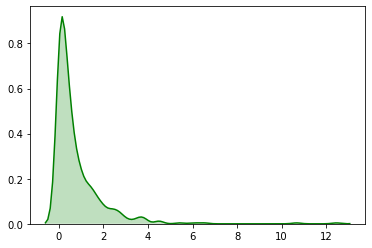

In [21]:
x2 = np.random.gamma(0.5,1.5,500)
sns.kdeplot(x2, shade = True, color ='green')

In [56]:
hd_est(x2, [0.005,0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

{0.005: 0.0001026091607708306,
 0.01: 0.00023360579607471338,
 0.025: 0.0005628945845730341,
 0.05: 0.002092419503388934,
 0.1: 0.010098622896611535,
 0.25: 0.07654820180228201,
 0.5: 0.33055578564850896,
 0.75: 0.9907951437148519,
 0.9: 2.08160919487015,
 0.95: 2.9171227460132703,
 0.975: 3.9172946219770206,
 0.99: 5.125171759805245}

Ta thử tiếp 1 phân bố 2 modes

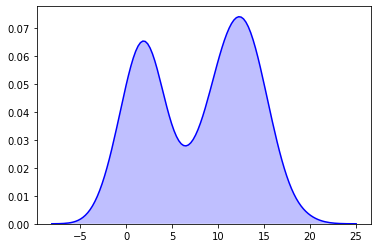

In [58]:
np.random.seed(123)

x1 = np.random.normal(loc=2, scale=2, size=1000)
x2 = np.random.normal(loc= 12, scale=3, size=1000)
b = np.random.binomial(1, 0.4, 1000)
x3 = x1*(b) + x2*(1-b)

sns.kdeplot(x3, shade = True, color ='blue')

In [59]:
hd_est(x3, [0.005,0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

{0.005: -2.6794773528069573,
 0.01: -2.1325375673411577,
 0.025: -1.3281861473835403,
 0.05: -0.581534694959542,
 0.1: 0.4413632431720716,
 0.25: 2.3896328260995574,
 0.5: 9.222760424625701,
 0.75: 12.761002429408897,
 0.9: 14.803737372537297,
 0.95: 15.922371588558345,
 0.975: 16.794441983269117,
 0.99: 18.255771606043165}

#  Khoảng tin cậy của Harrell-Davis quantile

Trước khi áp dụng phương pháp Harrell-Davis vào kiểm định so sánh, Nhi cần một bước trung gian, đó là dùng bootstrap để tái chọn mẫu rồi lặp lại việc ước tính phân vị rất nhiều lần; kết quả của quy trình bootstrap này sẽ cho phép ta xác định khoảng tin cậy của giá trị phân vị mục tiêu. 

Quy trình bootstrap cần 2 hàm, một hàm cơ bản tính Harrel-Davis quantile, một hàm tái chọn mẫu và ghi kết quả:

In [87]:
def boot_hdq(x, nboot = 1000, qseq = [0.5], alpha = 0.05):
    if isinstance(x, list):
        x = np.array(x)
    
    x = x[~np.isnan(x)]
    
    xb = np.random.choice(x, size = (nboot, x.shape[0]))
    xq = dict.fromkeys(qseq)
        
    def hd_est(x):
        xs = np.sort(x, axis=0)
        n = len(x)
        vec = np.arange(n)
        m1 = (n + 1) * q
        m2 = (n + 1) * (1 - q)
        wx = (stats.beta.cdf(vec/n, m1, m2) -
        stats.beta.cdf((vec-1)/n, m1, m2))
        hdq = (wx * xs).sum()
        return hdq
    
    for q in qseq:
        out = np.apply_along_axis(hd_est, 1, xb)
        
        xq[q] = out
            
    return xq

In [89]:
out_b = boot_hdq(x1, nboot = 1000, 
               qseq = [0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975])

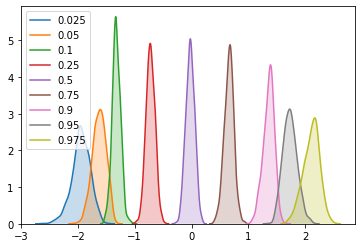

In [90]:
for i in out.keys():
    sns.kdeplot(out_b[i], shade = True, label = str(i))

In [102]:
for i in out_b.keys():
    print(f'{i}: CI:{np.quantile(out_b[i], [0.025,0.975])}')

0.025: CI:[-2.29881221 -1.64654963]
0.05: CI:[-1.86466703 -1.41614217]
0.1: CI:[-1.46719773 -1.17776609]
0.25: CI:[-0.87520349 -0.56814821]
0.5: CI:[-0.17365751  0.11945561]
0.75: CI:[0.48568342 0.81904807]
0.9: CI:[1.15170693 1.51956354]
0.95: CI:[1.50242132 1.97964521]
0.975: CI:[1.80027218 2.35846589]


In [91]:
out_b2 = boot_hdq(x2, nboot = 1000, 
               qseq = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, ])

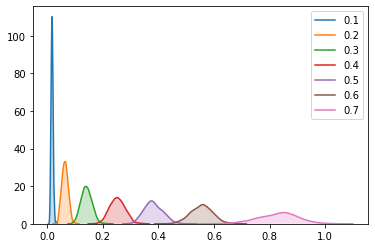

In [92]:
for i in out_b2.keys():
    sns.kdeplot(out_b2[i], shade = True, label = str(i))

In [160]:
for i in out_b2.keys():
    print(f'{i}: CI:{np.quantile(out_b2[i], [0.025,0.975])}')

0.1: CI:[0.0117782  0.02616592]
0.2: CI:[0.04426303 0.08626382]
0.3: CI:[0.10752658 0.17944012]
0.4: CI:[0.20301506 0.30508728]
0.5: CI:[0.32529098 0.44811184]
0.6: CI:[0.47803924 0.63282421]
0.7: CI:[0.68870262 0.95462812]


# Harrell-Davis quantile ứng dụng vào so sánh phân vị

Quan sát hình ảnh phân bố kết quả bootstrap của giá trị quantile, ta thấy đây là những phân bố Gaussian;

Khi có trong tay khoảng tin cậy như thế này, ta đã tiến rất gần đến một khả năng suy luận thống kê nhằm so sánh giữa 2 mẫu.
Như vậy, kết quả bootstrap của quantile theo Harrell-Davis có thể sử dụng như 1 trị số thống kê nhằm mục tiêu so sánh một phân vị bất kì giữa 2 mẫu, giống như cách ta dùng t-test để so sánh khác biệt giữa 2 trung bình.

Ta làm thí nghiệm: So sánh 5 phân vị thứ 5, 25, 50, 75 và 95 giữa 2 arrays x3 và x4:

Biểu đồ KDE cho thấy khác biệt giữa x3 và x4 là rất khó phân định:

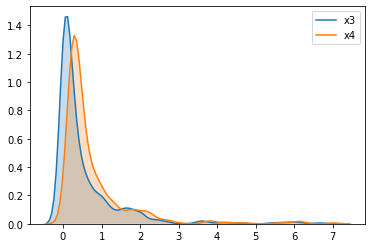

In [157]:
x3 = np.random.gamma(0.5,1,500)
x4 = x3 + np.random.normal(0.2,0.08,500)

sns.kdeplot(x3, shade = True, label ='x3')
sns.kdeplot(x4, shade = True, label = 'x4')

Ta áp dụng bootstrap để tính 100 lượt giá trị 5 phân vị cho x3 và x4:

In [158]:
out_3 = boot_hdq(x3, nboot = 100, 
               qseq = [0.05, 0.25, 0.5, 0.75, 0.95])

out_4 = boot_hdq(x4, nboot = 100, 
               qseq = [0.05, 0.25, 0.5, 0.75, 0.95])

Từ kết quả bootstrap, ta có thể so sánh dựa vào khoảng tin cậy 95% hoặc qua t-test

In [159]:
for i,j in zip(out_3.values(),out_4.values()):
    print(f'{np.quantile(i, [0.05, 0.95])} vs {np.quantile(j, [0.05, 0.95])}')
    print(f't-test p_value: {stats.ttest_ind(j,i, equal_var = False)[1]}')

[0.00066312 0.00203443] vs [0.14156541 0.16375873]
t-test p_value: 3.0349257818451876e-132
[0.03770581 0.06551957] vs [0.24338282 0.27312839]
t-test p_value: 2.6359684592235896e-210
[0.16325136 0.24102471] vs [0.3940512  0.44488012]
t-test p_value: 5.853636016932857e-135
[0.5431815 0.7667582] vs [0.79774761 0.96365408]
t-test p_value: 3.980773730577396e-61
[1.88146607 2.56247461] vs [2.11792573 2.71248339]
t-test p_value: 1.9393123592354956e-14


# Kết luận

Lợi ích của phương pháp Harrell-Davis ở chỗ nó cho phép ta ước tính được giá trị của bất kì phân vị nào mà không cần giả định về phân phối của dữ liệu; từ đó mở ra một khả năng so sánh bất cứ phân vị nào giữa 2 mẫu (những kiểm định thống kê trước kia chỉ nhằm so sánh giá trị trung bình); 

Bài thực hành đến đây tạm dừng, các bạn đã có trong tay: 

1 phép ước tính phân vị phi tham số theo Harrell Davis
1 phương pháp so sánh phi tham số nhằm vào các phân vị bất kì giữa 2 phân nhóm.

Hẹn gặp lại lần sau...